### PRIZM Data Prep Pipeline

In [1]:
from data_prep import DataPrep
from data_binning import *
import matplotlib.pyplot as plt
import numpy as np

#### Load Data

In [22]:
# Calibration type:
#'GSM' for antenna power - short power, 'raw' for antenna power
calib_type = 'GSM'

If getting data from the metadatabase:

In [4]:
instrument = '100MHz'
channel = 'EW'
year = '2021'

dataprep = DataPrep(instrument, channel, year)
# returns power, lst, systime
data, lst, systime = dataprep(calibration_type=calib_type)

To save output of DataPrep:

In [ ]:
path2file = '../Data/2021/100/EW/'
file_end = '_2021_100EW.npy'
arrays = [data, lst, systime]
names = ['data', 'lst', 'systime']

for i in range(len(names)):
    np.save(path2file + names[i] + file_end, arrays[i])

If uploading data from saved NumPy files:

In [33]:
path2file = '../rough/data/'
# path2file = '../DATA/2021/100/EW/'
file_ending = '_2021_100EW.npy'

with open(path2file + 'data' + file_ending, 'rb') as f:
    data = np.load(f)
with open(path2file + 'lst' + file_ending, 'rb') as f:
    lst = np.load(f)
if calib_type == 'GSM':
    with open(path2file + 'short_interp' + file_ending, 'rb') as f:
        short = np.load(f)
    data -= short

/tmp/ipykernel_85988/4060828350.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data[tstart:tstop]), cmap='jet', vmin=5)
/tmp/ipykernel_85988/4060828350.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.linspace(0,250,4096), lst[tstart:tstop],


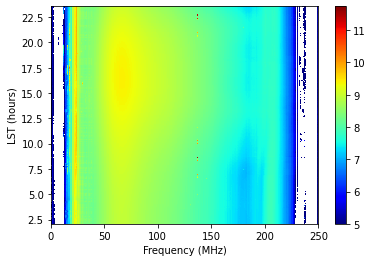

In [34]:
tstart = 16000
tstop = 26000

plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.pcolormesh(np.linspace(0,250,4096), lst[tstart:tstop], 
               np.log10(data[tstart:tstop]), cmap='jet', vmin=5)
plt.colorbar()
plt.show()

#### Data truncation and RFI excision

In [35]:
RFI = RFI_flagging(data, lst)
RFI()
data = RFI.data
freq = RFI.freq

/gpfs/fs1/home/s/sievers/nasuyu/.virtualenvs/prizmenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/gpfs/fs1/home/s/sievers/nasuyu/.virtualenvs/prizmenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


/tmp/ipykernel_85988/1844261870.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(freq, lst[tstart:tstop],


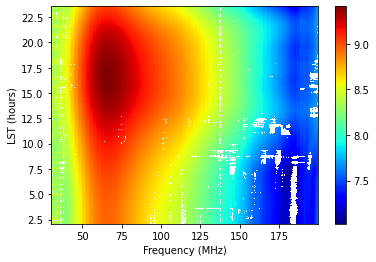

In [36]:
tstart = 16000
tstop = 26000

plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.pcolormesh(freq, lst[tstart:tstop], 
               np.log10(data[tstart:tstop]), cmap='jet')
plt.colorbar()
plt.show()

#### LST Binning

In [37]:
lst_bins, data_binned, _ = lst_binning(data, lst, binsize=2)

/gpfs/fs0/scratch/s/sievers/nasuyu/prizm-analysis/data_binning.py:52: RuntimeWarning: Mean of empty slice
  data_binned[i] = np.nanmean(data[bin_inds == i], axis=0)


/tmp/ipykernel_85988/1387135771.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(freq, lst_bins,


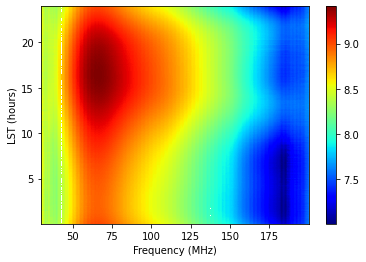

In [38]:
plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.pcolormesh(freq, lst_bins, 
               np.log10(data_binned), cmap='jet')
plt.colorbar()
plt.show()